<a href="https://colab.research.google.com/github/Kathy42xu/DL_TA/blob/main/lstm_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
device = tf.test.gpu_device_name()
print("GPU:", device)

!pip install yfinance ta

import yfinance as yf
df = yf.download("^GSPC", start="2002-08-01", end="2018-06-28")
df.to_csv("SP500.csv")


GPU: 
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4432b4063a7973ed85aa19501dc435beff1d1b12a62686225ad5d8745b742b1a
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


#preprocessing_indicator

In [2]:
import pandas as pd

# 1️⃣ 重新读取 CSV —— 明确告诉 pandas 用第一列作 index
df = pd.read_csv("SP500.csv", index_col=0, parse_dates=True)

# 2️⃣ 确认列名正确，只保留 Open/High/Low/Close/Volume
print(df.columns)
df = df[['Open','High','Low','Close','Volume']]

# 3️⃣ 强制转成浮点数（会把任何非数字变成 NaN）
df = df.apply(pd.to_numeric, errors='coerce')

# 4️⃣ 删除因转换失败产生的 NaN 行
df.dropna(inplace=True)

print(df.head())


Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
                  Open        High         Low       Close        Volume
Price                                                                   
2002-08-01  911.619995  911.619995  882.479980  884.659973  1.672200e+09
2002-08-02  884.400024  884.719971  853.950012  864.239990  1.538100e+09
2002-08-05  864.239990  864.239990  833.440002  834.599976  1.425500e+09
2002-08-06  834.599976  874.440002  834.599976  859.570007  1.514100e+09
2002-08-07  859.570007  878.739990  854.150024  876.770020  1.490400e+09


<ipython-input-2-dcf6b7282b58>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("SP500.csv", index_col=0, parse_dates=True)


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import ta

# -------------------------------
# 1) Read CSV with date parsing
# -------------------------------
df = pd.read_csv("SP500.csv", index_col=0, parse_dates=True)

# -------------------------------
# 2) Keep only OHLCV and convert to float
# -------------------------------
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

###############################################################################
# 3) Compute 43 Technical Indicators (Computed Features)
###############################################################################
# We'll compute 43 computed indicators, so that with the 5 raw columns,
# the final DataFrame has 43 + 5 = 48 columns.

# (1) Standard Deviation over 20 days (SD_20)
df['SD_20'] = df['Close'].rolling(20).std()

# (2-4) Simple Moving Averages (SMA)
df['SMA_5']  = ta.trend.sma_indicator(df['Close'], window=5)
df['SMA_10'] = ta.trend.sma_indicator(df['Close'], window=10)
df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)

# (5-7) Exponential Moving Averages (EMA)
df['EMA_6']  = ta.trend.ema_indicator(df['Close'], window=6)
df['EMA_10'] = ta.trend.ema_indicator(df['Close'], window=10)
df['EMA_14'] = ta.trend.ema_indicator(df['Close'], window=14)

# (8) MACD with fast=6, slow=12
df['MACD_6_12'] = ta.trend.macd_diff(df['Close'], window_slow=12, window_fast=6)

# (9-10) Relative Strength Index (RSI)
df['RSI_10'] = ta.momentum.rsi(df['Close'], window=10)
df['RSI_14'] = ta.momentum.rsi(df['Close'], window=14)

# (11) Commodity Channel Index (CCI)
df['CCI_20'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20)

# (12-13) Bollinger Bands (Upper and Lower)
df['BOLL_UB'] = ta.volatility.bollinger_hband(df['Close'], window=20)
df['BOLL_LB'] = ta.volatility.bollinger_lband(df['Close'], window=20)

# (14) Average True Range (ATR)
df['ATR_14'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'], window=14)

# (15-18) True Range Components: H-L, H-Cp, L-Cp, TR
df['H-L']  = df['High'] - df['Low']
df['H-Cp'] = (df['High'] - df['Close'].shift(1)).abs()
df['L-Cp'] = (df['Low']  - df['Close'].shift(1)).abs()
df['TR']   = df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1)

# (19) On-Balance Volume (OBV)
df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])

# (20) Money Flow Index (MFI) using library
df['MFI'] = ta.volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume'], window=14)

# (21) Force Index (1-day)
df['ForceIndex'] = ta.volume.force_index(df['Close'], df['Volume'], window=1)
# (22) 5-day Force Index (FI_5)
df['FI_5'] = ta.volume.force_index(df['Close'], df['Volume'], window=5)

# (23-24) Price and Volume Change Percentages (C%, V%)
df['C%'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)
df['V%'] = (df['Volume'] - df['Volume'].shift(1)) / df['Volume'].shift(1)

# (25) Negative Volume Index (NVI)
df['NVI'] = ta.volume.negative_volume_index(df['Close'], df['Volume'])

# (26) Ease of Movement (SEMV)
df['SEMV'] = ta.volume.ease_of_movement(df['High'], df['Low'], df['Volume'])

# (27) True Strength Index (TSI) – custom calculation
def tsi(series, long=25, short=13):
    diff = series.diff()
    abs_diff = diff.abs()
    ema1 = diff.ewm(span=long, adjust=False).mean()
    ema2 = ema1.ewm(span=short, adjust=False).mean()
    abs_ema1 = abs_diff.ewm(span=long, adjust=False).mean()
    abs_ema2 = abs_ema1.ewm(span=short, adjust=False).mean()
    return 100 * ema2 / abs_ema2

df['TSI'] = tsi(df['Close'], long=25, short=13)

# (28) Money Flow Ratio (MFR) – computed manually
df['PMF'] = np.where(df['Close'] > df['Close'].shift(1), df['Close'] * df['Volume'], 0)
df['NMF'] = np.where(df['Close'] < df['Close'].shift(1), df['Close'] * df['Volume'], 0)
df['PMF_roll'] = df['PMF'].rolling(14).sum()
df['NMF_roll'] = df['NMF'].rolling(14).sum()
df['MFR'] = df['PMF_roll'] / df['NMF_roll']

# (29) We'll include the library MFI as an additional indicator;
#     This gives you two MFI-related features: MFI (from above) and a custom one.
df['MFI_custom'] = 100 - (100 / (1 + df['MFR']))

# (30-31) Vortex Indicators: Upper (UVI) and Lower (LVI)
df['UVI'] = ta.trend.vortex_indicator_pos(df['High'], df['Low'], df['Close'], window=14)
df['LVI'] = ta.trend.vortex_indicator_neg(df['High'], df['Low'], df['Close'], window=14)

# (32-33) Know Sure Thing (KST) and its 9-day SMA signal (KST_9)
df['KST'] = ta.trend.kst(df['Close'])
df['KST_9'] = df['KST'].rolling(window=9).mean()

# (34) Detrended Price Oscillator (DPO, 20-day)
df['DPO_20'] = ta.trend.dpo(df['Close'], window=20)

# (35) Directional Index (DX) computed from ADX+ and ADX-
adx_pos_14 = ta.trend.adx_pos(df['High'], df['Low'], df['Close'], window=14)
adx_neg_14 = ta.trend.adx_neg(df['High'], df['Low'], df['Close'], window=14)
df['DX'] = 100 * (adx_pos_14 - adx_neg_14).abs() / (adx_pos_14 + adx_neg_14)

# (36-37) Average Directional Index (ADX) for 7-day and 14-day
df['ADX_7'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=7)
df['ADX_14'] = ta.trend.adx(df['High'], df['Low'], df['Close'], window=14)

# (38) Rate of Change (ROC, 12-day)
df['ROC_12'] = ta.momentum.roc(df['Close'], window=12)

# (39) Williams %R (with lookback period 14)
df['Williams_%R'] = ta.momentum.williams_r(df['High'], df['Low'], df['Close'], lbp=14)

# --- Extra 5 to reach 43 computed indicators ---

# (40) EMA of Volume (10-day)
df['EMA_Volume'] = ta.trend.ema_indicator(df['Volume'], window=10)

# (41) Rate of Change (ROC, 5-day)
df['ROC_5'] = ta.momentum.roc(df['Close'], window=5)

# (42) Bollinger Bandwidth: (UB - LB) / SMA_20
df['BOLL_BW'] = (df['BOLL_UB'] - df['BOLL_LB']) / df['SMA_20']

# (43) ATR Ratio: ATR_14 divided by SMA_20
df['ATR_Ratio'] = df['ATR_14'] / df['SMA_20']

# (44) Volatility: Coefficient of Variation = SD_20 / SMA_20
df['Vol_CV'] = df['SD_20'] / df['SMA_20']

###############################################################################
# Now, decide which computed indicators to keep.
# We want exactly 43 computed indicators. Currently, after the raw OHLCV,
# our DataFrame has extra intermediate columns.
#
# The current columns list (after computation) is:
# ['Open', 'High', 'Low', 'Close', 'Volume', 'SD_20', 'SMA_5', 'SMA_10', 'SMA_20',
#  'EMA_6', 'EMA_10', 'EMA_14', 'MACD_6_12', 'RSI_10', 'RSI_14', 'CCI_20',
#  'BOLL_UB', 'BOLL_LB', 'ATR_14', 'H-L', 'H-Cp', 'L-Cp', 'TR', 'OBV', 'MFI',
#  'ForceIndex', 'FI_5', 'C%', 'V%', 'NVI', 'SEMV', 'TSI', 'PMF', 'NMF', 'PMF_roll',
#  'NMF_roll', 'MFR', 'MFI_custom', 'UVI', 'LVI', 'KST', 'KST_9', 'DPO_20', 'DX',
#  'ADX_7', 'ADX_14', 'ROC_12', 'Williams_%R', 'EMA_Volume', 'ROC_5', 'BOLL_BW',
#  'ATR_Ratio', 'Vol_CV']
#
# We need to select 43 computed features from these.
#
# One common choice (based on the paper's indicator list) is to keep:
#    SMA_5, SMA_10, SMA_20,
#    EMA_6, EMA_10, EMA_14,
#    MACD_6_12,
#    RSI_10, RSI_14,
#    CCI_20,
#    BOLL_UB, BOLL_LB,
#    ATR_14,
#    H-L, H-Cp, L-Cp, TR,
#    OBV,
#    MFI,            # (library version)
#    ForceIndex, FI_5,
#    C%, V%,
#    NVI,
#    SEMV,
#    TSI,
#    MFR,            # Money Flow Ratio
#    UVI, LVI,
#    KST, KST_9,
#    DPO_20,
#    DX,
#    ADX_7, ADX_14,
#    ROC_12,
#    Williams_%R,
#    EMA_Volume,     # extra
#    ROC_5,          # extra
#    BOLL_BW,        # extra
#    ATR_Ratio,      # extra
#    Vol_CV          # extra
#
# That is a total of 43 computed indicators.
###############################################################################

computed_features = ['SD_20','SMA_5', 'SMA_10', 'SMA_20',
                     'EMA_6', 'EMA_10', 'EMA_14',
                     'MACD_6_12',
                     'RSI_10', 'RSI_14',
                     'CCI_20',
                     'BOLL_UB', 'BOLL_LB',
                     'ATR_14',
                     'H-L', 'H-Cp', 'L-Cp', 'TR',
                     'OBV',
                     'MFI',
                     'ForceIndex', 'FI_5',
                     'C%', 'V%',
                     'NVI',
                     'SEMV',
                     'TSI',
                     'MFR',
                     'UVI', 'LVI',
                     'KST', 'KST_9',
                     'DPO_20',
                     'DX',
                     'ADX_7', 'ADX_14',
                     'ROC_12',
                     'Williams_%R',
                     'EMA_Volume',
                     'ROC_5',
                     'BOLL_BW',
                     'ATR_Ratio',
                     'Vol_CV']

# Now, the final DataFrame should contain the 5 raw columns + these 43 computed features.
final_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] + computed_features
df_final = df[final_cols].copy()

###############################################################################
# 4) Normalization
###############################################################################
scaler = MinMaxScaler()
df_final[final_cols] = scaler.fit_transform(df_final[final_cols])

###############################################################################
# 5) Construct 50-day supervised sequences
###############################################################################
window = 50
# Compute next-day log returns (×100)
returns = 100 * np.log(df_final['Close'] / df_final['Close'].shift(1))
returns = returns.dropna()  # drop the first NaN row

X, y_reg, y_clf = [], [], []
for i in range(len(returns) - window):
    seq = df_final.iloc[i : i+window].values  # shape: (50, 48)
    X.append(seq)
    ret_val = returns.iloc[i+window]
    y_reg.append(ret_val)
    y_clf.append(int(ret_val > 0))

X = np.array(X)
y_reg = np.array(y_reg)
y_clf = np.array(y_clf)

###############################################################################
# 6) Save final dataset
###############################################################################
np.savez("SP500_preprocessed.npz", X=X, y_reg=y_reg, y_clf=y_clf)

print("Done!")
print("X shape:", X.shape)
print("y_reg shape:", y_reg.shape)
print("y_clf shape:", y_clf.shape)


<ipython-input-3-5a6f4f3969da>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("SP500.csv", index_col=0, parse_dates=True)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done!
X shape: (3954, 50, 48)
y_reg shape: (3954,)
y_clf shape: (3954,)


#Train LSTM

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.load("SP500_preprocessed.npz")
X, y_reg, y_clf = data['X'], data['y_reg'], data['y_clf']

# 按 70% train / 10% validation / 20% test 切分
X_temp, X_test, y_reg_temp, y_reg_test, y_clf_temp, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, shuffle=False)

X_train, X_val, y_reg_train, y_reg_val, y_clf_train, y_clf_val = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.125, shuffle=False)

print("Shapes → Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Shapes → Train: (2767, 50, 48) Val: (396, 50, 48) Test: (791, 50, 48)


In [5]:
mask = (~np.isnan(y_reg)) & (~np.isinf(y_reg))
X, y_reg, y_clf = X[mask], y_reg[mask], y_clf[mask]


##LFM

In [ ]:
# 1️⃣ Split data exactly as authors do
from sklearn.model_selection import train_test_split
X_temp, X_test, y_reg_temp, y_reg_test, y_clf_temp, y_clf_test = train_test_split(X, y_reg, y_clf, test_size=0.2, shuffle=False)
X_train, X_val, y_reg_train, y_reg_val, y_clf_train, y_clf_val = train_test_split(X_temp, y_reg_temp, y_clf_temp, test_size=0.125, shuffle=False)

# 2️⃣ Build exactly as original script
def build_model():
    inp = Input(shape=(50, X.shape[2]))
    x = LSTM(15, return_sequences=False)(inp)
    x = Dense(30, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(30, activation="relu")(x)
    out_reg = Dense(1, name="regression")(x)
    out_clf = Dense(2, activation="softmax", name="classification")(x)
    model = Model(inp, [out_reg, out_clf])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss={"regression":"mse", "classification":"sparse_categorical_crossentropy"},
        loss_weights={"regression":0.1, "classification":1.0}
    )
    return model

model = build_model()

# 3️⃣ Validate no NaNs in training batches
print("Train X NaNs:", np.isnan(X_train).sum(), "y_reg NaNs:", np.isnan(y_reg_train).sum())

# 4️⃣ Train
history = model.fit(
    X_train, {"regression":y_reg_train, "classification":y_clf_train},
    validation_data=(X_val, {"regression":y_reg_val, "classification":y_clf_val}),
    batch_size=256, epochs=300, callbacks=[EarlyStopping(patience=20, restore_best_weights=True)]
)


Train X NaNs: 0 y_reg NaNs: 0
Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - classification_loss: 0.6887 - loss: 5.0865 - regression_loss: 43.8788 - val_classification_loss: 0.6907 - val_loss: 0.8137 - val_regression_loss: 1.2653
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - classification_loss: 0.6914 - loss: 5.1222 - regression_loss: 44.2889 - val_classification_loss: 0.6910 - val_loss: 0.8129 - val_regression_loss: 1.2580
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - classification_loss: 0.6890 - loss: 4.1000 - regression_loss: 34.0164 - val_classification_loss: 0.6914 - val_loss: 0.8134 - val_regression_loss: 1.2609
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - classification_loss: 0.6871 - loss: 3.7978 - regression_loss: 30.9953 - val_classification_loss: 0.6912 - val_loss: 0.8128 - val_regression_loss: 1.2579
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - classification_loss: 0.6905 - loss: 3.1821 - regression_loss: 25.5191 - val_classificati

## paper logic:100 LSTM base model + learning rate halved every 50 epochs + 300 epochs fixed training + 13 randomly drawn features + bootstrap samples + final average prediction


In [ ]:
import numpy as np
import random
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import clone_model

def build_model(input_dim):
    inp = Input(shape=(50, input_dim))
    x = LSTM(15)(inp)
    x = Dense(30, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(30, activation="relu")(x)
    out_reg = Dense(1, name="regression")(x)
    out_clf = Dense(2, activation="softmax", name="classification")(x)
    model = Model(inp, [out_reg, out_clf])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss={"regression":"mse", "classification":"sparse_categorical_crossentropy"},
        loss_weights={"regression":0.1, "classification":1.0}
    )
    return model





# Learning rate schedule: halve every 50 epochs
def lr_schedule(epoch):
    return 1e-3 * (0.5 ** (epoch // 50))

lr_cb = LearningRateScheduler(lr_schedule)

ensemble_preds_reg = []
ensemble_preds_clf = []

for i in range(100):
    # Randomly sample 13 features
    features_idx = random.sample(range(X_train.shape[2]), 13)
    X_tr_sub = X_train[:,:,features_idx]
    X_val_sub = X_val[:,:,features_idx]
    X_test_sub = X_test[:,:,features_idx]

    # Bootstrap sample training data
    idx = np.random.choice(len(X_tr_sub), size=len(X_tr_sub), replace=True)
    X_boot, y_reg_boot, y_clf_boot = X_tr_sub[idx], y_reg_train[idx], y_clf_train[idx]

    # Build & train
    model_i = build_model(input_dim=X_train.shape[2] if False else X_boot.shape[2])
    model_i.fit(
        X_boot, {"regression": y_reg_boot, "classification": y_clf_boot},
        validation_data=(X_val_sub, {"regression": y_reg_val, "classification": y_clf_val}),
        epochs=300, batch_size=256, callbacks=[lr_cb], verbose=0
    )

    # Predict on test
    reg_pred, clf_pred = model_i.predict(X_test_sub, verbose=0)
    ensemble_preds_reg.append(reg_pred.flatten())
    ensemble_preds_clf.append(clf_pred)

# Average ensemble outputs
final_reg = np.mean(np.vstack(ensemble_preds_reg), axis=0)
final_clf = np.mean(np.stack(ensemble_preds_clf), axis=0).argmax(axis=1)

print("Ensemble Test RMSE:", np.sqrt(((final_reg - y_reg_test)**2).mean()))
from sklearn.metrics import balanced_accuracy_score
print("Ensemble Test BACC:", balanced_accuracy_score(y_clf_test, final_clf))


#multi task


NaNs per column in final DataFrame:
Open            0
High            0
Low             0
Close           0
Volume          0
SD_20          19
SMA_5           4
SMA_10          9
SMA_20         19
EMA_6           5
EMA_10          9
EMA_14         13
MACD_6_12      19
RSI_10          9
RSI_14         13
CCI_20         19
BOLL_UB        19
BOLL_LB        19
ATR_14          0
H-L             0
H-Cp            1
L-Cp            1
TR              0
OBV             0
MFI            13
ForceIndex      1
FI_5            5
C%              1
V%              1
NVI             0
SEMV            1
TSI             1
MFR            13
UVI            14
LVI            14
KST            14
KST_9          22
DPO_20         19
DX             15
ADX_7           0
ADX_14          0
ROC_12         12
Williams_%R    13
EMA_Volume      9
ROC_5           5
BOLL_BW        19
ATR_Ratio      19
Vol_CV         19
dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Before filtering, X shape: (3954, 50, 48)
After filtering, X shape: (3932, 50, 48)
y_reg shape: (3932,) y_clf shape: (3932,)
Dataset saved successfully!


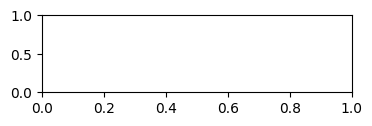

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Assume df_final has been created as in your preprocessing cell ---
# final_cols = ['Open','High','Low','Close','Volume'] + computed_features
# df_final = df[final_cols].copy()

# Check if any NaNs remain in df_final
print("NaNs per column in final DataFrame:")
print(df_final.isna().sum())

# Normalize the final DataFrame
scaler = MinMaxScaler()
final_cols = df_final.columns.tolist()
df_final[final_cols] = scaler.fit_transform(df_final[final_cols])

# Compute next-day log returns and drop the first row
returns = 100 * np.log(df_final['Close'] / df_final['Close'].shift(1))
returns = returns.dropna()

# Construct 50-day sequences
window = 50
X, y_reg, y_clf = [], [], []
for i in range(len(returns) - window):
    seq = df_final.iloc[i : i+window].values  # each seq: shape (50, 48)
    X.append(seq)
    ret_val = returns.iloc[i+window]
    y_reg.append(ret_val)
    y_clf.append(int(ret_val > 0))

X = np.array(X)
y_reg = np.array(y_reg)
y_clf = np.array(y_clf)

print("Before filtering, X shape:", X.shape)

# Filter out any sequences that contain NaN values
valid_mask = ~np.isnan(X).any(axis=(1, 2))
X = X[valid_mask]
y_reg = y_reg[valid_mask]
y_clf = y_clf[valid_mask]

print("After filtering, X shape:", X.shape)
print("y_reg shape:", y_reg.shape, "y_clf shape:", y_clf.shape)

# Save the dataset
np.savez("SP500_preprocessed.npz", X=X, y_reg=y_reg, y_clf=y_clf)
print("Dataset saved successfully!")


In [7]:
import numpy as np
import math
import random
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import mean_squared_error, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------------------
# 1) Load preprocessed dataset (assumed normalized and with 48 features per timestep)
# ------------------------------------------------------------------------------
data = np.load("SP500_preprocessed.npz")
X, y_reg, y_clf = data['X'], data['y_reg'], data['y_clf']
print("Preprocessed dataset shapes:")
print("X:", X.shape, "y_reg:", y_reg.shape, "y_clf:", y_clf.shape)

# ------------------------------------------------------------------------------
# 2) Data cleaning: remove samples with NaN/Inf and clip regression targets
# ------------------------------------------------------------------------------
mask = (~np.isnan(y_reg)) & (~np.isinf(y_reg))
X, y_reg, y_clf = X[mask], y_reg[mask], y_clf[mask]
y_reg = np.clip(y_reg, -10, 10)

# ------------------------------------------------------------------------------
# 3) Split data exactly as authors do:
#    70% train / 10% validation / 20% test (without shuffling)
# ------------------------------------------------------------------------------
X_temp, X_test, y_reg_temp, y_reg_test, y_clf_temp, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, shuffle=False)
X_train, X_val, y_reg_train, y_reg_val, y_clf_train, y_clf_val = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.125, shuffle=False)
print("Shapes → Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ------------------------------------------------------------------------------
# 4) Model building function
# ------------------------------------------------------------------------------
def build_model(input_dim):
    inp = Input(shape=(50, input_dim))
    # Shared layers:
    x = LSTM(15, return_sequences=False)(inp)
    x = Dense(30, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(30, activation="relu")(x)

    # Regression branch: 3 Dense layers
    reg_branch = Dense(30, activation="relu")(x)
    reg_branch = Dense(30, activation="relu")(reg_branch)
    reg_branch = Dense(30, activation="relu")(reg_branch)
    out_reg = Dense(1, name="regression")(reg_branch)

    # Classification branch: 3 Dense layers
    clf_branch = Dense(30, activation="relu")(x)
    clf_branch = Dense(30, activation="relu")(clf_branch)
    clf_branch = Dense(30, activation="relu")(clf_branch)
    out_clf = Dense(2, activation="softmax", name="classification")(clf_branch)

    model = Model(inputs=inp, outputs=[out_reg, out_clf])
    # Use MSE for regression and cross-entropy for classification
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss={"regression": "mse",
                        "classification": "sparse_categorical_crossentropy"},
                  loss_weights={"regression": 0.1, "classification": 1.0})
    return model

# ------------------------------------------------------------------------------
# 5) Learning rate scheduler and early stopping
# ------------------------------------------------------------------------------
def lr_schedule(epoch, lr):
    # Halve the learning rate every 50 epochs
    return 1e-3 * (0.5 ** (epoch // 50))
lr_cb = LearningRateScheduler(lr_schedule)
es_cb = EarlyStopping(patience=20, restore_best_weights=True)

# ------------------------------------------------------------------------------
# 6) Ensemble training settings
# ------------------------------------------------------------------------------
num_models = 100      # Number of ensemble models (as in the paper)
feature_subset = 13   # Number of features to randomly sample per model

ensemble_preds_reg = []
ensemble_preds_clf = []

for i in range(num_models):
    print(f"Training model {i+1}/{num_models} ...")
    # Randomly sample feature indices from 0 to total features-1 (total features = 48)
    feature_idx = sorted(random.sample(range(X_train.shape[2]), feature_subset))

    # Select features from training, validation, and test sets accordingly
    X_train_sub = X_train[:, :, feature_idx]
    X_val_sub   = X_val[:, :, feature_idx]
    X_test_sub  = X_test[:, :, feature_idx]

    # Bootstrap sample the training data
    indices = np.random.choice(len(X_train_sub), size=len(X_train_sub), replace=True)
    X_boot = X_train_sub[indices]
    y_reg_boot = y_reg_train[indices]
    y_clf_boot = y_clf_train[indices]

    # Build and train the model on the bootstrap sample
    model_i = build_model(input_dim=feature_subset)
    es_inner = EarlyStopping(patience=20, restore_best_weights=True)

    model_i.fit(
        X_boot, {"regression": y_reg_boot, "classification": y_clf_boot},
        validation_data=(X_val_sub, {"regression": y_reg_val, "classification": y_clf_val}),
        epochs=300,
        batch_size=256,
        callbacks=[lr_cb, es_inner],
        verbose=0
    )

    # Predict on the test set with the same feature subset
    pred_reg_i, pred_clf_i = model_i.predict(X_test_sub, verbose=0)
    ensemble_preds_reg.append(pred_reg_i.flatten())
    ensemble_preds_clf.append(pred_clf_i)

# ------------------------------------------------------------------------------
# 7) Aggregate ensemble predictions
# ------------------------------------------------------------------------------
final_pred_reg = np.mean(np.vstack(ensemble_preds_reg), axis=0)
final_pred_clf_prob = np.mean(np.stack(ensemble_preds_clf), axis=0)
final_pred_clf = final_pred_clf_prob.argmax(axis=1)

# ------------------------------------------------------------------------------
# 8) Evaluate ensemble performance
# ------------------------------------------------------------------------------
rmse = math.sqrt(mean_squared_error(y_reg_test, final_pred_reg))
acc = accuracy_score(y_clf_test, final_pred_clf)
bacc = balanced_accuracy_score(y_clf_test, final_pred_clf)

print("Ensemble Test RMSE:", rmse)
print("Ensemble Test Accuracy:", acc)
print("Ensemble Test Balanced Accuracy:", bacc)


Preprocessed dataset shapes:
X: (3932, 50, 48) y_reg: (3932,) y_clf: (3932,)
Shapes → Train: (2751, 50, 48) Val: (393, 50, 48) Test: (786, 50, 48)
Training model 1/100 ...
Training model 2/100 ...
Training model 3/100 ...
Training model 4/100 ...
Training model 5/100 ...
Training model 6/100 ...
Training model 7/100 ...
Training model 8/100 ...
Training model 9/100 ...
Training model 10/100 ...
Training model 11/100 ...
Training model 12/100 ...
Training model 13/100 ...
Training model 14/100 ...
Training model 15/100 ...
Training model 16/100 ...
Training model 17/100 ...
Training model 18/100 ...
Training model 19/100 ...
Training model 20/100 ...
Training model 21/100 ...
Training model 22/100 ...
Training model 23/100 ...
Training model 24/100 ...
Training model 25/100 ...
Training model 26/100 ...
Training model 27/100 ...
Training model 28/100 ...
Training model 29/100 ...
Training model 30/100 ...
Training model 31/100 ...
Training model 32/100 ...
Training model 33/100 ...
Trai

Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - classification_loss: 0.6902 - loss: 1.6525 - regression_loss: 9.6198 - val_classification_loss: 0.6940 - val_loss: 0.8144 - val_regression_loss: 1.2579 - learning_rate: 0.0010
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - classification_loss: 0.6891 - loss: 1.7102 - regression_loss: 10.2013 - val_classification_loss: 0.6940 - val_loss: 0.8142 - val_regression_loss: 1.2564 - learning_rate: 0.0010
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - classification_loss: 0.6884 - loss: 1.6891 - regression_loss: 10.0136 - val_classification_loss: 0.6941 - val_loss: 0.8143 - val_regression_loss: 1.2567 - learning_rate: 0.0010
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - classification_loss: 0.6921 - loss: 1.6825 - regression_loss: 9.8930 - val_classification_loss: 0.6925 - val_loss: 0.8133 - val_regression_loss: 1.2583 - learning_rate: 0.0010
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - classification_loss: 0

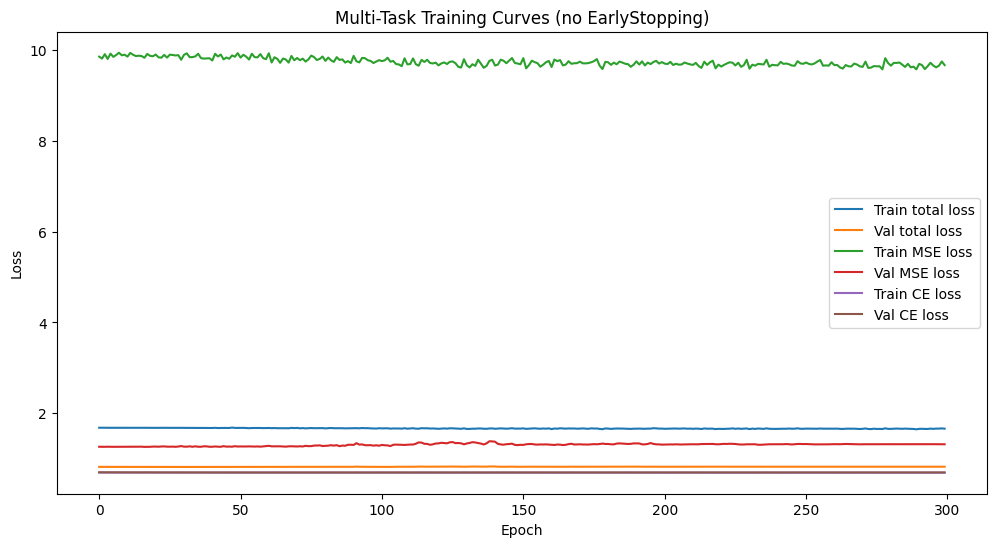

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

# 1) Load & split data
data = np.load("SP500_preprocessed.npz")
X, y_reg, y_clf = data['X'], data['y_reg'], data['y_clf']
mask = (~np.isnan(y_reg)) & (~np.isinf(y_reg))
X, y_reg, y_clf = X[mask], y_reg[mask], y_clf[mask]
y_reg = np.clip(y_reg, -10, 10)

X_temp, X_test, y_reg_temp, y_reg_test, y_clf_temp, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, shuffle=False)
X_train, X_val, y_reg_train, y_reg_val, y_clf_train, y_clf_val = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.125, shuffle=False)

# 2) Build model function
def build_model(input_dim):
    inp = Input(shape=(50, input_dim))
    x = LSTM(15)(inp)
    x = Dense(30, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(30, activation="relu")(x)
    # regression branch
    r = Dense(30, activation="relu")(x)
    r = Dense(30, activation="relu")(r)
    r = Dense(30, activation="relu")(r)
    out_reg = Dense(1, name="regression")(r)
    # classification branch
    c = Dense(30, activation="relu")(x)
    c = Dense(30, activation="relu")(c)
    c = Dense(30, activation="relu")(c)
    out_clf = Dense(2, activation="softmax", name="classification")(c)
    model = Model(inp, [out_reg, out_clf])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss={"regression":"mse","classification":"sparse_categorical_crossentropy"},
        loss_weights={"regression":0.1,"classification":1.0}
    )
    return model

# 3) Learning rate scheduler
def lr_schedule(epoch, lr):
    return 1e-3 * (0.5 ** (epoch // 50))
lr_cb = LearningRateScheduler(lr_schedule)

# 4) Prepare one subset of features (first 13 for example)
feature_subset = 13
feature_idx = list(range(feature_subset))
X_train_sub = X_train[:, :, feature_idx]
X_val_sub   = X_val[:, :, feature_idx]

# 5) Train one model without EarlyStopping
model = build_model(input_dim=feature_subset)
history = model.fit(
    X_train_sub, {"regression": y_reg_train, "classification": y_clf_train},
    validation_data=(X_val_sub, {"regression": y_reg_val, "classification": y_clf_val}),
    epochs=300,
    batch_size=256,
    callbacks=[lr_cb],
    verbose=1
)

# 6) Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train total loss')
plt.plot(history.history['val_loss'], label='Val total loss')
plt.plot(history.history['regression_loss'], label='Train MSE loss')
plt.plot(history.history['val_regression_loss'], label='Val MSE loss')
plt.plot(history.history['classification_loss'], label='Train CE loss')
plt.plot(history.history['val_classification_loss'], label='Val CE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-Task Training Curves (no EarlyStopping)')
plt.legend()
plt.show()


Shapes → Train: (2751, 50, 48) Val: (393, 50, 48) Test: (786, 50, 48)
Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - classification_loss: 0.6897 - loss: 1.6857 - regression_loss: 9.9634 - val_classification_loss: 0.6909 - val_loss: 0.8119 - val_regression_loss: 1.2569 - learning_rate: 0.0010
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - classification_loss: 0.6894 - loss: 1.7077 - regression_loss: 10.1784 - val_classification_loss: 0.6908 - val_loss: 0.8120 - val_regression_loss: 1.2575 - learning_rate: 0.0010
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - classification_loss: 0.6866 - loss: 1.6942 - regression_loss: 10.0720 - val_classification_loss: 0.6911 - val_loss: 0.8120 - val_regression_loss: 1.2565 - learning_rate: 0.0010
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - classification_loss: 0.6899 - loss: 1.6918 - regression_loss: 10.0171 - val_classification_loss: 0.6905 - val_loss: 0.8120 - val_regression_loss: 1.2585 - learning_rate: 0.0010
Epoch 

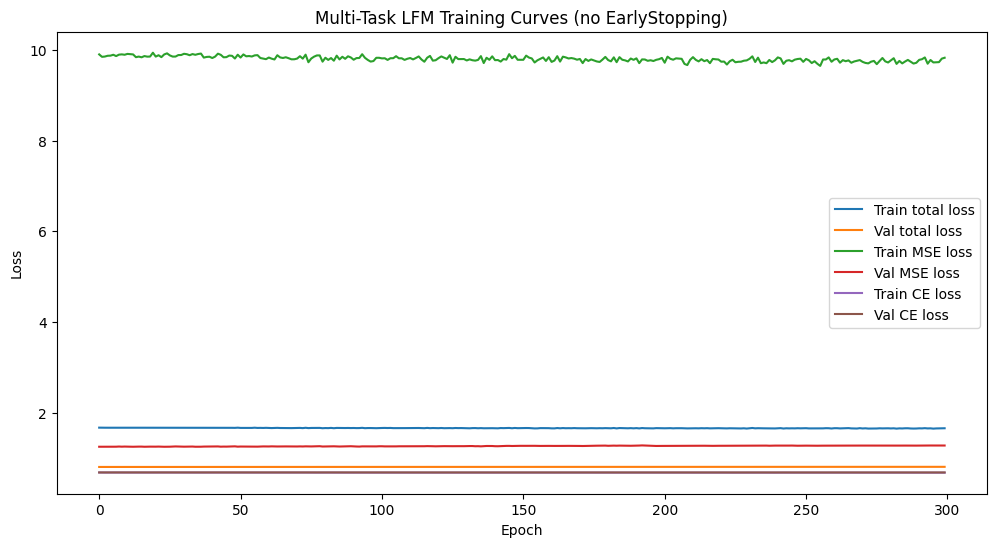

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

# 1) 加载并清洗数据
data = np.load("SP500_preprocessed.npz")
X, y_reg, y_clf = data['X'], data['y_reg'], data['y_clf']
mask = (~np.isnan(y_reg)) & (~np.isinf(y_reg))
X, y_reg, y_clf = X[mask], y_reg[mask], y_clf[mask]
y_reg = np.clip(y_reg, -10, 10)

# 2) 切分数据：70% 训练 / 10% 验证 / 20% 测试（不打乱）
X_temp, X_test, y_reg_temp, y_reg_test, y_clf_temp, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, shuffle=False)
X_train, X_val, y_reg_train, y_reg_val, y_clf_train, y_clf_val = train_test_split(
    X_temp, y_reg_temp, y_clf_temp, test_size=0.125, shuffle=False)

print("Shapes → Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# 3) 定义模型构造函数
def build_model(input_dim):
    inp = Input(shape=(50, input_dim))
    # 共享层
    x = LSTM(15)(inp)
    x = Dense(30, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(30, activation="relu")(x)
    # 回归分支
    r = Dense(30, activation="relu")(x)
    r = Dense(30, activation="relu")(r)
    r = Dense(30, activation="relu")(r)
    out_reg = Dense(1, name="regression")(r)
    # 分类分支
    c = Dense(30, activation="relu")(x)
    c = Dense(30, activation="relu")(c)
    c = Dense(30, activation="relu")(c)
    out_clf = Dense(2, activation="softmax", name="classification")(c)
    model = Model(inp, [out_reg, out_clf])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss={"regression":"mse", "classification":"sparse_categorical_crossentropy"},
        loss_weights={"regression":0.1, "classification":1.0}
    )
    return model

# 4) 学习率调度（每 50 轮减半）
def lr_schedule(epoch, lr):
    return 1e-3 * (0.5 ** (epoch // 50))
lr_cb = LearningRateScheduler(lr_schedule)

# 5) 取固定的 13 维特征子集（示例取前 13 个）
feature_subset = 13
feature_idx = list(range(feature_subset))
X_train_sub = X_train[:, :, feature_idx]
X_val_sub   = X_val[:, :, feature_idx]

# 6) 训练 300 轮，不使用 EarlyStopping
model = build_model(input_dim=feature_subset)
history = model.fit(
    X_train_sub,
    {"regression": y_reg_train, "classification": y_clf_train},
    validation_data=(X_val_sub, {"regression": y_reg_val, "classification": y_clf_val}),
    epochs=300,
    batch_size=256,
    callbacks=[lr_cb],
    verbose=1
)

# 7) 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train total loss')
plt.plot(history.history['val_loss'], label='Val total loss')
plt.plot(history.history['regression_loss'], label='Train MSE loss')
plt.plot(history.history['val_regression_loss'], label='Val MSE loss')
plt.plot(history.history['classification_loss'], label='Train CE loss')
plt.plot(history.history['val_classification_loss'], label='Val CE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Multi-Task LFM Training Curves (no EarlyStopping)')
plt.legend()
plt.show()
